In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['kagglecatsanddogs_3367a']


# Cats and Dogs with CNN TensorFlow

This notebook is to recreate the code from [pythonprogramming.net](https://pythonprogramming.net/loading-custom-data-deep-learning-python-tensorflow-keras/) tutorials. The goal is to understand the code and how CNN models works in classifying and image of a cats or dogs using the Cats and Dogs [dataset](https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle
import time


## Data

In [3]:
DATADIR = '../input/kagglecatsanddogs_3367a/PetImages'
CATEGORIES = ['Dog','Cat']

## Preprocess Dataset

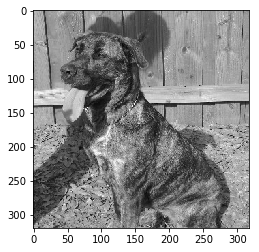

In [4]:
#Iterate and convert datasets to an array.

for category in CATEGORIES:
    path = os.path.join(DATADIR, category) # path to dataset directory
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap='gray')
        plt.show()
        break
    break

In [5]:
# Checking Data
print('Data Array:\n',img_array,'\n')
print('Data Shape:',img_array.shape)

Data Array:
 [[200 190 198 ... 144 145 153]
 [199 186 194 ... 162 159 156]
 [194 182 189 ... 138 141 143]
 ...
 [118 156 157 ... 114 136 142]
 [ 54 164 208 ... 131  88 162]
 [ 60 108 185 ... 145 198 204]] 

Data Shape: (320, 317)


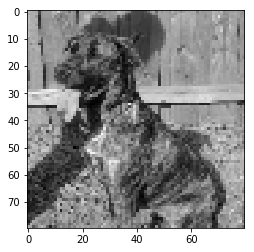

In [6]:
# Resize the image
IMG_SIZE = 80
new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

In [7]:
# Create dataset for training

training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category) # categories for dog(0) and cat(1)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                training_data.append([new_array,class_num])
            except Exception as e:
                pass
        
create_training_data()

In [8]:
print(len(training_data))

24946


In [9]:
# Reshuffle Data
random.shuffle(training_data)

# Check the shuffled data
for sample in training_data [:10]:
    print(sample[1])

0
1
0
1
1
1
1
1
0
1


In [10]:
# Create list for training data
X = [] # feature dataset
y = [] # label dataset

for features, label in training_data:
    X.append(features)
    y.append(label)

# Convert X to an array since you can't pass it to a neural network
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(X[:1])

[[[[  4]
   [  5]
   [  5]
   ...
   [168]
   [ 38]
   [ 41]]

  [[  2]
   [  3]
   [  3]
   ...
   [131]
   [ 39]
   [ 31]]

  [[  8]
   [  3]
   [  4]
   ...
   [ 35]
   [ 48]
   [ 41]]

  ...

  [[205]
   [228]
   [230]
   ...
   [113]
   [ 63]
   [ 59]]

  [[228]
   [232]
   [211]
   ...
   [ 64]
   [202]
   [ 72]]

  [[211]
   [220]
   [237]
   ...
   [236]
   [231]
   [198]]]]


In [11]:
# Save traing set using pickle

pickle_out = open('X.pickle', 'wb')
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('y.pickle', 'wb')
pickle.dump(y, pickle_out)
pickle_out.close()

In [12]:
# Open pickle file

pickle_in = open('X.pickle','rb')
X = pickle.load(pickle_in)
X[1]

array([[[25],
        [26],
        [26],
        ...,
        [73],
        [77],
        [81]],

       [[27],
        [28],
        [29],
        ...,
        [77],
        [80],
        [84]],

       [[29],
        [29],
        [32],
        ...,
        [80],
        [84],
        [88]],

       ...,

       [[61],
        [64],
        [67],
        ...,
        [29],
        [29],
        [33]],

       [[61],
        [63],
        [64],
        ...,
        [30],
        [26],
        [37]],

       [[57],
        [62],
        [62],
        ...,
        [32],
        [25],
        [39]]], dtype=uint8)

## The Model

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

In [14]:
# Callback Name for Tensorboard
NAME = 'Cats-vs-Dogs-64x2-CNN-{}'.format(int(time.time()))

In [15]:
# Optimizing GPU
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [16]:
# Load saved datasets

pickle_in = open('X.pickle','rb')
X = pickle.load(pickle_in)

pickle_in = open('y.pickle','rb')
y = pickle.load(pickle_in)

In [17]:
# Normalized Datasets
X = X/255.0

In [18]:
# Build Model

model = Sequential()

model.add(Conv2D(64, (3,3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) #to convert 3D feature map to 1D
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

tensorboard = TensorBoard(log_dir='./output/{}'.format(NAME))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, y, batch_size=32, epochs=10, validation_split=0.3, callbacks=[tensorboard])

Train on 17462 samples, validate on 7484 samples
Epoch 1/10
17462/17462 [==============================] - 15s 837us/step - loss: 0.6398 - acc: 0.6293 - val_loss: 0.5848 - val_acc: 0.6912
Epoch 2/10
17462/17462 [==============================] - 13s 755us/step - loss: 0.5249 - acc: 0.7390 - val_loss: 0.5298 - val_acc: 0.7461
Epoch 3/10
17462/17462 [==============================] - 13s 754us/step - loss: 0.4509 - acc: 0.7894 - val_loss: 0.5012 - val_acc: 0.7565
Epoch 4/10
17462/17462 [==============================] - 13s 755us/step - loss: 0.4010 - acc: 0.8177 - val_loss: 0.4747 - val_acc: 0.7819
Epoch 5/10
17462/17462 [==============================] - 13s 755us/step - loss: 0.3448 - acc: 0.8469 - val_loss: 0.4999 - val_acc: 0.7798
Epoch 6/10
17462/17462 [==============================] - 13s 754us/step - loss: 0.2891 - acc: 0.8751 - val_loss: 0.5941 - val_acc: 0.7488
Epoch 7/10
17462/17462 [==============================] - 13s 753us/step - loss: 0.2211 - acc: 0.9093 - val_loss: 0.5